In [128]:
! activate ai-azure-c1

import sys

sys.path.append("/opt/conda/envs/ai-azure-c1/lib/python3.8/site-packages")

In [129]:
!pip install Pillow==8.4

In [130]:
import io
import datetime
import pandas as pd
from PIL import Image
import requests
import io
import glob, os, sys, time, uuid

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw

from video_indexer import VideoIndexer
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials

In [131]:
video_analysis = VideoIndexer(
    vi_subscription_key='080f710d4f8545e9bfd9794541a904aa',
    vi_location="trial",
    vi_account_id="2f105a34-4008-4ad7-9c50-ae8747db92c9"
)

# Upload Video

In [ ]:
uploaded_video_id = video_analysis.upload_to_video_indexer(
   input_filename='/home/workspace/avkash-boarding-pass.mp4',
   video_name='avkash-boarding-pass',  # unique identifier for video in Video Indexer platform
   video_language='English'
)

In [140]:
info = video_analysis.get_video_info(uploaded_video_id, video_language='English')

Getting video info for: 195f502b8f


In [141]:
video_analysis.check_access_token()

In [142]:
video_id = '195f502b8f'

In [143]:
video_analysis.get_video_info(video_id)

Getting video info for: 195f502b8f


{'partition': None,
 'description': None,
 'privacyMode': 'Private',
 'state': 'Processed',
 'accountId': '2f105a34-4008-4ad7-9c50-ae8747db92c9',
 'id': '195f502b8f',
 'name': 'avkash-boarding-pass',
 'userName': 'ODL_User 216623',
 'created': '2022-11-25T18:22:29.3153+00:00',
 'isOwned': True,
 'isEditable': True,
 'isBase': True,
 'durationInSeconds': 26,
 'duration': '0:00:26.499856',
 'summarizedInsights': {'name': 'avkash-boarding-pass',
  'id': '195f502b8f',
  'privacyMode': 'Private',
  'duration': {'time': '0:00:26.499856', 'seconds': 26.5},
  'thumbnailVideoId': '195f502b8f',
  'thumbnailId': 'a9f1dab5-748b-4926-9d88-f54a5c1dfe74',
  'faces': [{'videoId': '195f502b8f',
    'confidence': 0,
    'description': None,
    'title': None,
    'thumbnailId': '414bf4af-a839-4391-a911-b01acd51efc4',
    'seenDuration': 26.4,
    'seenDurationRatio': 0.9962,
    'id': 1000,
    'name': 'Unknown #1',
    'appearances': [{'startTime': '0:00:00',
      'endTime': '0:00:26.3666666',
      '

In [176]:
info = video_analysis.get_video_info(video_id, video_language='English')

Getting video info for: 195f502b8f


In [177]:
if len(info['videos'][0]['insights']['faces'][0]['thumbnails']):
    print("We found {} faces in this video.".format(str(len(info['videos'][0]['insights']['faces'][0]['thumbnails']))))

We found 6 faces in this video.


# Display emotion and sentiments

In [178]:
info['summarizedInsights']['sentiments']

[]

In [179]:
info['summarizedInsights']['emotions']

[]

# Show face thumbnails

In [180]:
images = []
img_raw = []
img_strs = []
for each_thumb in info['videos'][0]['insights']['faces'][0]['thumbnails']:
    if 'fileName' in each_thumb and 'id' in each_thumb:
        file_name = each_thumb['fileName']
        thumb_id = each_thumb['id']
        img_code = video_analysis.get_thumbnail_from_video_indexer(video_id,  thumb_id)
        img_strs.append(img_code)
        img_stream = io.BytesIO(img_code)
        img_raw.append(img_stream)
        img = Image.open(img_stream)
        images.append(img)

Getting thumbnail from video: 195f502b8f, thumbnail: 1955c2c7-9ccd-48a7-a4f1-63042ce1e73f
Getting thumbnail from video: 195f502b8f, thumbnail: 51f298e1-ed86-44e6-b18c-9790be027c30
Getting thumbnail from video: 195f502b8f, thumbnail: 218e109f-488e-4e56-87a0-af665e99dcb3
Getting thumbnail from video: 195f502b8f, thumbnail: d2bb58fb-2180-4471-915f-2ac03d517afc
Getting thumbnail from video: 195f502b8f, thumbnail: b173a266-3b6f-49a9-9ef2-65f5440ebfaf
Getting thumbnail from video: 195f502b8f, thumbnail: 414bf4af-a839-4391-a911-b01acd51efc4


{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}
{'comment': b'Lavc59.18.100\x00'}


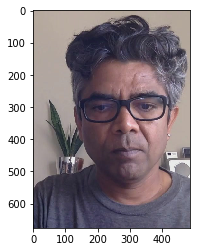

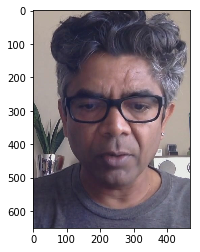

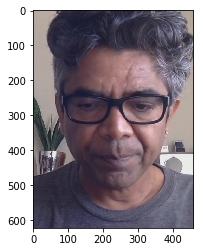

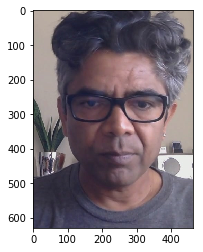

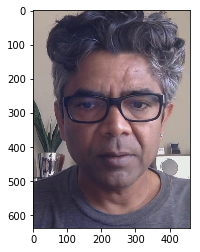

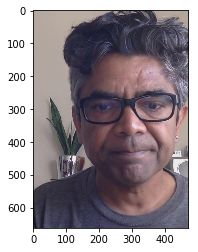

In [181]:
for img in images:
    print(img.info)
    plt.figure()
    plt.imshow(img)

# Save thumbnails to disk

In [ ]:
i = 1
for img in images:
    print(type(img))
    img.save('kiosk-face' + str(i) + '.jpg')
    i= i+ 1

# Create FaceAPI client

In [153]:
# Create a client
face_client = FaceClient("d55dd882c50a4eadac2b17ee341e1bd0", CognitiveServicesCredentials("https://kiosk-face-api.cognitiveservices.azure.com/"))

In [154]:
face_client.api_version

'1.0'

# Create Person model for thumbnails

In [192]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'person-avkash-kiosk'

In [183]:
## This code is taken from Azure face SDK 
## ---------------------------------------
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    client.person_group.create(person_group_id = person_group_id, name=person_group_id)

    # Create a person group person.
    my_face = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg images of human in working directory.
    my_face_images = [file for file in glob.glob('*.jpg') if file.startswith("kiosk-face")]
    # Add images to a Person object
    for image_p in my_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, my_face.person_id, w)

    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)

In [196]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: 724ac8d9-b401-4154-9742-e70f7ded8c21
Training status: running.
Training status: succeeded.


# Avkash ID is verified via Face API

In [197]:
dl_faces = face_client.face.detect_with_url("https://raw.githubusercontent.com/natebuel29/cd0461-building-computer-vision-solutions-with-azure-project-starter/master/starter/digital_id_template/ca-dl-avkash.png")
dl_faces[0].face_id

'a1381337-9e94-4630-b999-44528a799086'

In [201]:
# Enter the face ID of ca-dl-sample.png from the output of the cell above
get_the_face_id_from_the_sample = 'a1381337-9e94-4630-b999-44528a799086'

In [202]:
person_gp_results = face_client.face.identify([get_the_face_id_from_the_sample], PERSON_GROUP_ID)

In [203]:
for result in person_gp_results:
    if result.candidates:
        for candidate in result.candidates:
            print("The Identity match confidence is {}".format(candidate.confidence))
    else:
        print("Can't verify the identity with the person group")

The Identity match confidence is 0.8152
